# Libraries

In [ ]:
!pip install moviepy==2.1.1
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CS211.P11 - Đồ án cuối kỳ/'

/content/drive/MyDrive/CS211.P11 - Đồ án cuối kỳ


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
from moviepy import *
import os
from tqdm import tqdm
from torch.distributions.categorical import Categorical
from IPython.display import Video
import time

# Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.model(state)

# Used functions

In [ ]:
# Hàm khởi tạo trọng số
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Hàm tính độ mới
def compute_novelty(new_behavior, behavior_archive, k=5):
    if not behavior_archive:
        return 0
    distances = [np.linalg.norm(behavior - new_behavior) for behavior in behavior_archive]
    sorted_distances = np.sort(distances)
    selected = sorted_distances[np.argwhere(sorted_distances > 0)]
    return np.mean(selected[:k]) if len(selected) > 0 else 0.1      # smoothed

# Hàm tính đặc trưng hành vi
def behavior_characterization(policy, env, episodes=1, max_step_per_episode = 200, seed = 1):
    behaviors = []
    for _ in range(episodes):
        step = 0
        state = env.reset(seed=seed)
        done = False
        trajectory = []
        while not done:
            if type(state) == tuple:
                state = state[0]
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = Categorical(action_probs).sample().item()
            next_state, _, done, _, _ = env.step(action)
            trajectory.append(state)
            step += 1
            state = next_state
            if done or step == max_step_per_episode:
                break
        behaviors.append(np.mean(trajectory, axis=0))       # Lấy trung bình các trạng thái của tập phát sinh
    return np.mean(behaviors, axis=0)                       # Lấy trung bình trên các tập phát sinh

# Hàm đánh giá chiến lược, trả về giá trị đặc trưng hành vi và điểm thưởng trung bình
def evaluate_policy(policy, env, episodes=1, max_step_per_episode = 200, seed = 1):
    behaviors = []
    total_rewards = 0
    for _ in range(episodes):
        step = 0
        state = env.reset(seed=seed)
        done = False
        trajectory = []
        while not done:
            if type(state) == tuple:
                state = state[0]
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = Categorical(action_probs).sample().item()
            next_state, reward, done, _, _ = env.step(action)
            trajectory.append(state)
            total_rewards += reward
            step += 1
            state = next_state
            if done or step == max_step_per_episode:
                break
        behaviors.append(np.mean(trajectory, axis=0))                   # Lấy trung bình các trạng thái của tập phát sinh
    return np.mean(behaviors, axis=0), total_rewards / episodes         # Lấy trung bình trên các tập phát sinh

# Hàm chơi game
def play(env_id, policy, seed, max_step, capture_video = True, video_output_path = 'output_video.mp4'):
    env = gym.make(env_id, render_mode='rgb_array')
    state = env.reset(seed=seed)
    frames = []
    done = False
    i = 0
    total_rewards = 0
    while not done:
            frame = env.render()
            frames.append(frame)
            if type(state) == tuple:
                state = state[0]
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = Categorical(action_probs).sample().item()
            next_state, reward, done, _, _ = env.step(action)
            total_rewards += reward
            state = next_state
            i+=1
            if i == max_step:
                break
    env.close()
    if capture_video:
        clip = ImageSequenceClip(frames, fps=30)
        clip.write_videofile(video_output_path, codec="libx264")
    return i, total_rewards

# Hàm hiển thị video chơi game
def display_video(video_path):
    return Video(video_path, embed=True, width=720, height=480)

# Parameters & Hyperparameters

In [ ]:
# Parameters
env_id = 'CartPole-v0'
env = gym.make(env_id)
state_dim = 4
action_dim = 2    # (0, 1)

# Hyperparameters
seed = 21521992
pop_size = 10               # Kích thước quần thể (số lượng chính sách được duy trì qua mỗi bước lặp)
num_episodes_per_eval = 3   # Số lượng tập phát sinh khi đánh giá chính sách
update_frequency = 1000
max_step_per_episode = 500  # Giới hạn số bước tối đa cho mỗi tập
sigma = 0.1
alpha = 0.001
n_workers = 5
max_iterations = 10000

# Tạo thư mục lưu trữ kết quả
save_dir = f"1runs/NS-ES/{env_id}__{seed}"
video_output_dir = f'1videos/NS-ES/{env_id}__{seed}'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)
video_result_log = f'1videos/NS-ES/{env_id}__{seed}/video_log.txt'

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


# NS-ES Training

![Alt text](https://i.imgur.com/YlaQiRQ.png")

In [ ]:
all_best_states = []
all_best_rewards = []
all_novelties = []
training_times = []

# Khởi tạo
population = [NeuralNetwork(state_dim=state_dim, action_dim=action_dim).apply(initialize_weights) for _ in range(pop_size)]
behavior_archive = deque(maxlen=100)
rewards = []

# Tính toán BC và thêm vào archive
for policy in population:
    behavior_archive.append(behavior_characterization(policy, env, num_episodes_per_eval, max_step_per_episode, seed))

for iter in tqdm(range(max_iterations)):
    # Tính điểm thưởng của quần thể hiện tại
    pop_rewards = []
    pop_behaviors = []
    pop_novelties = []

    start_time = time.time()

    # Tính toán behavior + novelty (để sample) và điểm thưởng của quần thể
    for policy in population:
        behavior, reward = evaluate_policy(policy, env, num_episodes_per_eval, max_step_per_episode, seed)
        pop_rewards.append(reward)
        pop_behaviors.append(behavior)
        pop_novelties.append(compute_novelty(behavior, behavior_archive))

    best_index = np.argmax(pop_rewards)
    all_best_rewards.append(max(pop_rewards))
    all_best_states.append(population[best_index].state_dict())

    # Sample
    probs = [novelty / sum(pop_novelties) for novelty in pop_novelties]
    selected_index = np.random.choice(range(pop_size), p=probs)
    # selected_index = np.random.choice(range(pop_size))
    # print(selected_index)
    selected_policy = population[selected_index]

    # Thêm nhiễu
    policies = [selected_policy for _ in range(n_workers)]
    new_novelties = []
    noises = []
    for i in range(n_workers):
        policy_noises = []
        for param in policies[i].parameters():
            if param.requires_grad:
                noise = torch.normal(0, sigma, size=param.size(), device=param.device)
                policy_noises.append(noise)
                param.data.add_(noise)
        noises.append(policy_noises)
        bc = behavior_characterization(policies[i], env, num_episodes_per_eval, max_step_per_episode, seed)
        new_novelties.append(compute_novelty(bc, behavior_archive))

    # Cập nhật chính sách
    novelty_mean = torch.mean(torch.tensor(new_novelties, device=param.device))
    for param_idx, param in enumerate(population[selected_index].parameters()):
        if param.requires_grad:
            param_noises = torch.stack([noises[i][param_idx] for i in range(n_workers)])
            noise_mean = torch.mean(param_noises, dim=0)
            # scale dựa theo phân phối
            # novelty_std = torch.std(torch.tensor(new_novelties, device=param.device))
            # if novelty_std > 0:
            #     norm_novelty = (torch.tensor(new_novelties, device=param.device) - novelty_mean) / novelty_std
            # else:
            #     norm_novelty = torch.zeros_like(torch.tensor(new_novelties, device=param.device))


            # scale bằng hàm kích hoạt phi tuyến
            # norm_novelty = torch.tanh(torch.tensor(new_novelties, device=param.device))       # hoặc đổi thành sigmoid

            # scale_value =  torch.mean(norm_novelty)
            # update_value = alpha * (1 / sigma) * scale_value * noise

            update_value = alpha * novelty_mean * (1 / sigma) * noise_mean
            param.data.add_(update_value)

    # Thêm vào archive
    bc = behavior_characterization(population[selected_index], env, num_episodes_per_eval, max_step_per_episode, seed)
    all_novelties.append(compute_novelty(bc, behavior_archive))
    behavior_archive.append(bc)

    training_times.append(time.time() - start_time)

    if (iter+1) % update_frequency == 0:
        # Lưu trạng thái quần thể
        np.savez_compressed(os.path.join(save_dir,f'results.npz'),
                            rewards = all_best_rewards, novelties = all_novelties, training_times = training_times)
        torch.save(all_best_states, os.path.join(save_dir,f"Iteration_{iter+1}.pt"))

    if (iter+1) % 100 == 0:
        best_new_novelty = np.max(all_novelties[-5:]) if iter >= 5 else np.max(all_novelties)
        best_new_reward = np.max(all_best_rewards[-5:]) if iter >= 5 else np.max(all_best_rewards)
        print(f"Iteration {iter+1}/{max_iterations}, Best new novelty: {best_new_novelty:.2f}, Best new reward: {best_new_reward:.2f}, Total executing time: {sum(training_times):.2f} seconds")

        # Chơi game và lưu video
        best_policy_state = all_best_states[-100:][np.argsort(all_best_rewards[-100:])[-1]]
        best_policy = NeuralNetwork(state_dim=state_dim, action_dim=action_dim)
        best_policy.load_state_dict(best_policy_state)
        best_policy.eval()
        total_step, total_reward = play(env_id, best_policy, seed, max_step_per_episode, capture_video=True,
                                    video_output_path=os.path.join(video_output_dir,f'Iteration_{iter+1}.mp4'))

        # Các kết quả của file video được lưu ở file log
        log = f'Iteration: {iter+1}. Total step: {total_step}. Total reward: {total_reward}\n'
        with open(video_result_log, "a", encoding="utf-8") as file:
            file.write(log)

## Results

In [ ]:
def load_results(file_path):
    result = np.load(file_path)
    all_best_rewards = result['rewards']
    training_times = result['training_times']
    return all_best_rewards, training_times

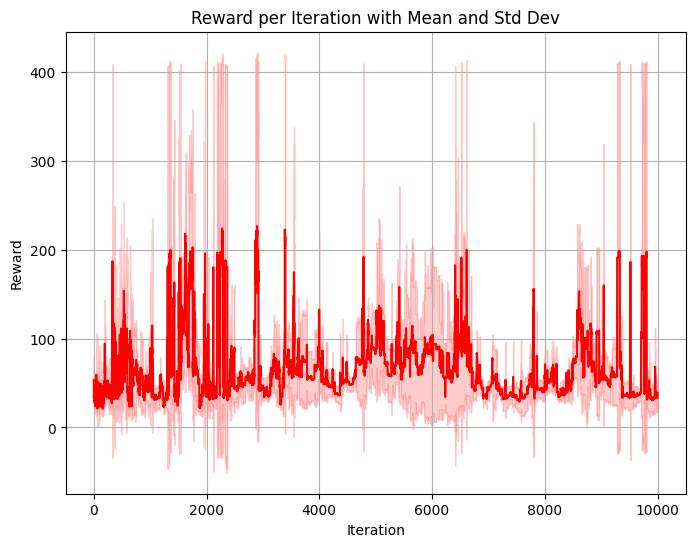

In [ ]:
rws1, tms1 = load_results('runs/NS-ES/CartPole-v0__21520398 (1)/results.npz')
rws2, tms2 = load_results('runs/NS-ES/CartPole-v0__21520445/results.npz')
rws3, tms3 = load_results('runs/NS-ES/CartPole-v0__21521992/results.npz')
all_rewards = np.array([rws1, rws2, rws3])
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Vẽ đồ thị
plt.figure(figsize=(8, 6))
iterations = range(len(mean_rewards))

plt.plot(iterations, mean_rewards, color='red')
plt.fill_between(iterations,
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 color='red', alpha=0.2, label='Std Dev')

plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward per Iteration with Mean and Std Dev')
plt.grid(True)
plt.show()

In [ ]:
display_video('videos/NS-ES/CartPole-v0__21520398/Iteration_9300.mp4')

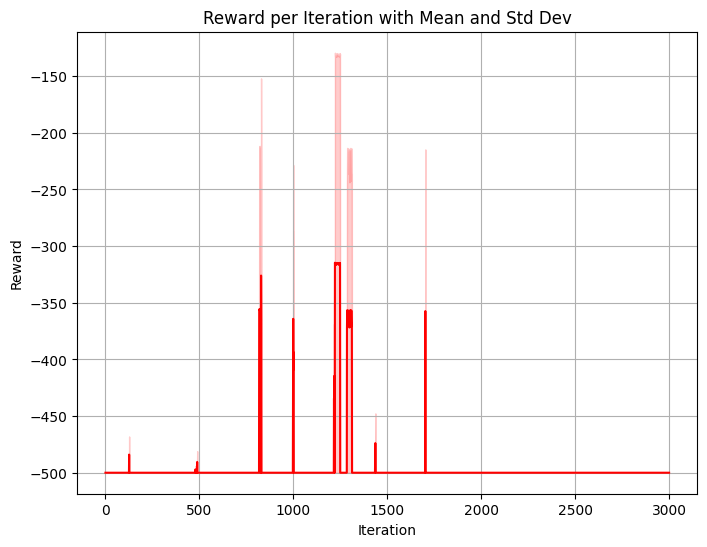

In [ ]:
rws1, tms1 = load_results('runs/NS-ES/MountainCar-v0__21520398/results.npz')
rws2, tms2 = load_results('runs/NS-ES/MountainCar-v0__21521992/results.npz')
all_rewards = np.array([rws1, rws2])
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Vẽ đồ thị
plt.figure(figsize=(8, 6))
iterations = range(len(mean_rewards))

plt.plot(iterations, mean_rewards, color='red')
plt.fill_between(iterations,
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 color='red', alpha=0.2, label='Std Dev')

plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward per Iteration with Mean and Std Dev')
plt.grid(True)
plt.show()

In [ ]:
display_video('videos/NS-ES/MountainCar-v0__21520398/Iteration_1000.mp4')

# NSR-ES Training

![Alt text](https://i.imgur.com/yHmAAbI.png)

In [ ]:
# Tạo thư mục lưu trữ kết quả
save_dir = f"1runs/NSR-ES/{env_id}__{seed}"
video_output_dir = f'1videos/NSR-ES/{env_id}__{seed}'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)
video_result_log = f'1videos/NSR-ES/{env_id}__{seed}/video_log.txt'

# hyperparameters
reward_weight  = 0.5        # trọng số cập nhật dựa theo phần thưởng
novelty_weight = 1 - reward_weight

In [ ]:
all_best_states = []
all_best_rewards = []
all_novelties = []
training_times = []

# Khởi tạo
population = [NeuralNetwork(state_dim=state_dim, action_dim=action_dim).apply(initialize_weights) for _ in range(pop_size)]
behavior_archive = deque(maxlen=100)
rewards = []

# Tính toán BC và thêm vào archive
for policy in population:
    behavior_archive.append(behavior_characterization(policy, env, num_episodes_per_eval, max_step_per_episode, seed))

for iter in tqdm(range(max_iterations)):
    # Tính điểm thưởng của quần thể hiện tại
    pop_rewards = []
    pop_behaviors = []
    pop_novelties = []

    start_time = time.time()

    # Tính toán behavior + novelty (để sample) và điểm thưởng của quần thể
    for policy in population:
        behavior, reward = evaluate_policy(policy, env, num_episodes_per_eval, max_step_per_episode, seed)
        pop_rewards.append(reward)
        pop_behaviors.append(behavior)
        pop_novelties.append(compute_novelty(behavior, behavior_archive))

    best_index = np.argmax(pop_rewards)
    all_best_rewards.append(max(pop_rewards))
    all_best_states.append(population[best_index].state_dict())

    # Sample
    probs = [novelty / sum(pop_novelties) for novelty in pop_novelties]
    selected_index = np.random.choice(range(pop_size), p=probs)
    # selected_index = np.random.choice(range(pop_size))
    # print(selected_index)
    selected_policy = population[selected_index]

    # Thêm nhiễu
    policies = [selected_policy for _ in range(n_workers)]
    new_novelties = []
    noises = []
    new_rewards = []
    for i in range(n_workers):
        policy_noises = []
        for param in policies[i].parameters():
            if param.requires_grad:
                noise = torch.normal(0, sigma, size=param.size(), device=param.device)
                policy_noises.append(noise)
                param.data.add_(noise)
        noises.append(policy_noises)
        bc, rw = evaluate_policy(policies[i], env, num_episodes_per_eval, max_step_per_episode, seed)
        new_novelties.append(compute_novelty(bc, behavior_archive))
        new_rewards.append(rw)

    # Cập nhật chính sách
    novelty_mean = torch.mean(torch.tensor(new_novelties, device=param.device))
    reward_mean = torch.mean(torch.tensor(new_rewards, device=param.device))
    for param_idx, param in enumerate(population[selected_index].parameters()):
        if param.requires_grad:
            param_noises = torch.stack([noises[i][param_idx] for i in range(n_workers)])
            noise_mean = torch.mean(param_noises, dim=0)

            # scale bằng hàm kích hoạt phi tuyến
            norm_reward = torch.tanh(reward_mean)
            norm_novelty = torch.tanh(novelty_mean)
            scale_value = reward_weight * torch.mean(norm_reward) + novelty_weight * torch.mean(norm_novelty)

            update_value = alpha * (1 / sigma) * scale_value * noise_mean
            param.data.add_(update_value)

    # Thêm vào archive
    bc = behavior_characterization(population[selected_index], env, num_episodes_per_eval, max_step_per_episode, seed)
    all_novelties.append(compute_novelty(bc, behavior_archive))
    behavior_archive.append(bc)

    training_times.append(time.time() - start_time)

    if (iter+1) % update_frequency == 0:
        # Lưu trạng thái quần thể
        np.savez_compressed(os.path.join(save_dir,f'results.npz'),
                            rewards = all_best_rewards, novelties = all_novelties, training_times = training_times)
        torch.save(all_best_states, os.path.join(save_dir,f"Iteration_{iter+1}.pt"))

    if (iter+1) % 100 == 0:
        best_new_novelty = np.max(all_novelties[-5:]) if iter >= 5 else np.max(all_novelties)
        best_new_reward = np.max(all_best_rewards[-5:]) if iter >= 5 else np.max(all_best_rewards)
        print(f"Iteration {iter+1}/{max_iterations}, Best new novelty: {best_new_novelty:.2f}, Best new reward: {best_new_reward:.2f}, Total executing time: {sum(training_times):.2f} seconds")

        # Chơi game và lưu video
        best_policy_state = all_best_states[-100:][np.argsort(all_best_rewards[-100:])[-1]]
        best_policy = NeuralNetwork(state_dim=state_dim, action_dim=action_dim)
        best_policy.load_state_dict(best_policy_state)
        best_policy.eval()

        total_step, total_reward = play(env_id, best_policy, seed, max_step_per_episode, capture_video=True,
                                    video_output_path=os.path.join(video_output_dir,f'Iteration_{iter+1}.mp4'))
        # Các kết quả của file video được lưu ở file log
        log = f'Iteration: {iter+1}. Total step: {total_step}. Total reward: {total_reward}\n'
        with open(video_result_log, "a", encoding="utf-8") as file:
            file.write(log)

## Results

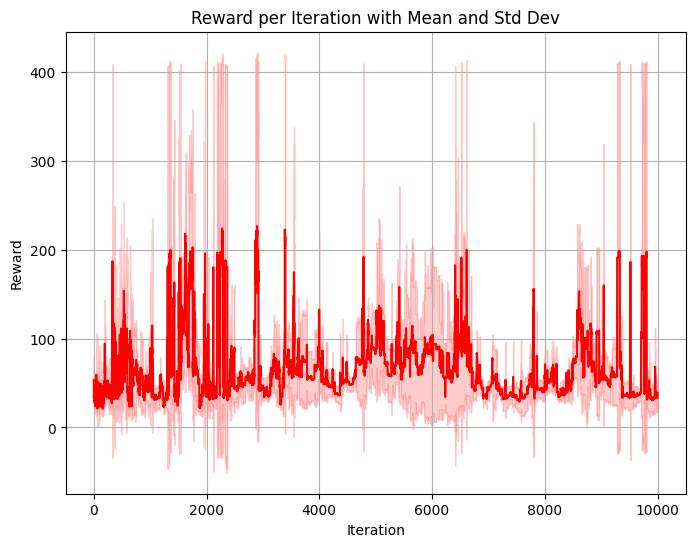

In [ ]:
rws1, tms1 = load_results('runs/NSR-ES/CartPole-v0__21520398 (1)/results.npz')
rws2, tms2 = load_results('runs/NSR-ES/CartPole-v0__21520445/results.npz')
rws3, tms3 = load_results('runs/NSR-ES/CartPole-v0__21521992/results.npz')
all_rewards = np.array([rws1, rws2, rws3])
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Vẽ đồ thị
plt.figure(figsize=(8, 6))
iterations = range(len(mean_rewards))

plt.plot(iterations, mean_rewards, color='red')
plt.fill_between(iterations,
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 color='red', alpha=0.2, label='Std Dev')

plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward per Iteration with Mean and Std Dev')
plt.grid(True)
plt.show()

In [ ]:
display_video('videos/NSR-ES/CartPole-v0__21521992/Iteration_3400.mp4')